# Capital One Data Science Challenge

### Candidate ID: C1194345  (v19.04)

## Problem Statement
***
Given around ~640,000 credit card transactions that loosely resembles real transactional data from Capital One credit card customers. The objective is to build a predictive model to determine whether a given transaction will be fraudulent or not. A wide variety of attributes on the transactions were provided which includes customerId, currentBalance, transactionAmount, merchantName etc.

## Approach
***
> 1. ### Understanding the Dataset
>> - The credit card transactions dataset was provided in a text file with each transaction represented in line-delimited JSON format. The dataset consisted of 641,914 rows with 29 columns. The columns included a combination of date, boolean, int, float and string datatypes.
>> - As the dataset has many missing values in the form of whitespaces, they have been replaced with `NA` values and dropped the columns having 100% of missing records.
>> - Columns with date type such as accountOpenDate, currentExpDate, etc. were of string type and were converted to datetime format.
>> - The dataset included the transactions of 5000 unique customers with their transactions in the year of 2016 starting from 2016-01-01 to 2016-12-31.
>> - These 5000 accounts were opened at different dates ranging from 1985-12-25 to 2015-12-31.
>> - The transactions information included merchant attributes such as merchant category, merchant name, merchant city, merchant state, etc.
>> - The majority of the transactions are based in the USA.
> 1. ### Exploratory Data Analysis
>> - Out of 641,914 credit card transactions, the dataset only included 11,302 transactions that have been tagged as fraud. The fraud transactions accounts to only 1.76% of records in the dataset.
>> - There are four important columns associated to amounts for credit card transactions namely availableMoney, creditLimit, currentBalance and transactionAmount. 
>> - The creditLimit ranges from `$2,500` to `$50,000` with average credit limit of `$10,000` for customers.
>> - The transaction amount for each transaction ranges from `$0` to `$1,825` with average amount per transaction of `$135`.
>> - The current balance column is a cumulative sum of the transaction amount for each month for the customer by transaction and the available money column is indicative of the remaining balance after the transaction.
>> - In order to understand the distribution of the numeric columns such as avaialble money, transaction amount etc. I have used histograms and box plots.
>> - To visualize the spread of fraud among various string columns such as merchantcategoryCode, posentrycode, posentrymode, etc. I have used stacked bar charts. I have also checked for unique values in the object columns and was able to see the transactions were spread accross 2493 merchants with 19 different categories such as fastfood, online_retail, etc.
>> - I  have used the correlation heat map to understand the interactions between the independent and dependent variables. There was no significant correlation among the independent and the dependent variables.
> 1. ### Model Building
>> #### Feature Engineering
>> - My approach is pretty straightforward which mainly revolves around feature engineering. I tried many different combination of features and found the below three feature sets to be most useful.
>> - I have discarded the accounts with opening date in the year 1985 as they were very few of them and did not have any fraud related transactions and thought might not be much helpful for model.
>>> 1. `Customer based features`: I have built customer based aggregated features such as min, median, mean, max of transaction amounts.
>>>> - unique credit cards present
>>>> - aggregared feature of customer based on specific credit card such as min, median, mean, max of transaction amounts.
>>>> - Customer activity in the based with combination to below mentioned temporal feauters etc.
>>> 1. `Temporal features`: Temporal features almost always helps boosted trees as most of the time these models can leverage the cross-sectional correlation of the data (e.g. interaction between different features at a given observation level) but there is no way for the model to tackle the time dimension (e.g. latent interaction between two or more observations recorded at different time points). by infusing these featues explicitly - the model can also learn the cross-time correlation e.g. how transactions of customer in the past affects the nature of transaction of a customer at present. This is very important.
>>>> - The temporal features that I considered are:
>>>> - Account Age - days between account open date and transaction date
>>>> - Days since last transaction
>>>> - The sequential transaction number of a customer in a particular merchant category, company, etc
>>>> - Days since last transaction of a customer in a particular merchant category, company, etc
>>>> - cumulative count of same day tranasactions of a customer in a particular merchant category, company, etc
>>> 1. `Merchant based features`: I have built merchant based features based on merchant category, merchant parent company and merchant store by calculating entropy by customer, target mean encoding, etc.
>>>> - I have also built aggregated features such as min, median, mean, max of transaction amounts by merchant store, merchant company and merchant category.
>>> 1. `Ratio features`: I created a number of ratios between:
>>>> - Ratio of transaction amount to credit limit
>>>> - Ratio of transaction amount to account age
>>>> - Ratio of credit limit to account age
>>>> - Ratio of transaction amount to current balance and more
>>> 1. `Date features`: A lot of date based features such as transactionDay, transactionMonth, transactionYear, etc.
>> #### Model Training & Testing: 
>>>> - The rich set of 149 features were built and the data was split into train and test sets by transaction date as reference. I have split the records into train having transaction dates starting from 2016-01-01 to 2016-11-30. The test dataset consisted of records for the month of December 2016.
>>>> - The missing value imputation was done using a simple median impute technique as there were not many missing values in the dataset.
>>>> - The validation set was built from train using a time series split with 20% of data in the validation.
>>>> - As the dataset is highly unbalanced I prefer to use Area Under the Curve as my metric to evaluate the model performance.
>>>> - I have played with different ML algorithms such as random forest, CatBoost, LightGBM, XGBoost,etc. but the solution will have only LightGBM implementation as it gave the best results to predict fraud with an AUC score of 0.829 on the validation and test sets and is consistent.
> 1. ### Questions & Future Work:
>> - Fraud is common in every industry however it is also specific to every industry. If there was a data dictionary provided I would have come up with more valid assumptions.
>> - If I had more time, I would implemented model explainability using shap values. I would also analyzed the data more in depth and build ensemble models to see if it increases the model performance in predicting the fraud. More detailed explaination of various approaches I tried in the course of solving this problem.

## How to run the solution
***
This code was tested on python >= 3.6

1. Please install the following packages in the package section below. All of the packages are download using pip. 
2. Please install fastai package using `pip install fastai`. Reference: `https://github.com/fastai/fastai`

### Loading Packages

In [1]:
from fastai.imports import *
from fastai.structured import *
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from datetime import date
from IPython.display import display
pd.set_option('display.max_columns', None)
from datetime import datetime
from dateutil.parser import parse
from scipy.stats import entropy
from math import log, e

%matplotlib inline
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [12, 8]})

In [2]:
import xgboost as xgb
from catboost import CatBoostClassifier, Pool, cv
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
from sklearn.model_selection import KFold
from sklearn import metrics

### Custom Functions

In [4]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)
        
def get_stats(df,columns, bins):
    fig, axs = plt.subplots(1,2)
    for column in columns:
        df2 = df[np.isfinite(df[column])]
        count, division = np.histogram(df2[column], bins=bins)
        null_value_stats = df[df[column].isnull()]
        print(f"Column name: {column}")
        print(f"Total Rows: {len(df)}")
        print(f"Positive values row count: {len(df[(df[column]>=0)])}")
        print(f"Negative values row count: {len(df[(df[column]<0)])}")
        print(f"Null values row count: {null_value_stats.shape[0]}")
        print(f"Column summary")
        print(df[column].describe())
        print(f"Cut: {division}")
        print(f"Count: {count}")
        df.boxplot(column=[column], ax=axs[0])
        df[column].plot.hist(bins=bins, alpha=0.5, ax=axs[1])
        
dateparse = lambda x: pd.datetime.strptime(x, '%d/%m/%y')

def generate_date_features(df, fldname, drop=True):
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre+"_isweekend"]=df[targ_pre+"Dayofweek"].apply(lambda x:1 if x==5 or x==6 else 0)
    if drop: df.drop(fldname, axis=1, inplace=True)
    
def count_encode(train, test, by_cols, on_col, name, use_test=False):
    temp=train.groupby(by_cols)[on_col].count().reset_index().rename(columns={on_col:name})
    train=pd.merge(train,temp,how='left',on=by_cols)
    if use_test:
        temp=test.groupby(by_cols)[on_col].count().reset_index().rename(columns={on_col:name})
    test=pd.merge(test,temp,how='left',on=by_cols)
    train[name].fillna(np.median(temp[name]),inplace=True)
    test[name].fillna(np.median(temp[name]),inplace=True)
    return train,test


def train_test_split_sorted(X, y, test_size, dates):

    n_test = math.ceil(test_size * len(X))

    sorted_index = [x for _, x in sorted(zip(np.array(dates), np.arange(0, len(dates))), key=lambda pair: pair[0])]
    train_idx = sorted_index[:-n_test]
    test_idx = sorted_index[-n_test:]

    if isinstance(X, (pd.Series, pd.DataFrame)):
        X_train = X.iloc[train_idx]
        X_test = X.iloc[test_idx]
    else:
        X_train = X[train_idx]
        X_test = X[test_idx]
    if isinstance(y, (pd.Series, pd.DataFrame)):
        y_train = y.iloc[train_idx]
        y_test = y.iloc[test_idx]
    else:
        y_train = y[train_idx]
        y_test = y[test_idx]

    return X_train, X_test, y_train, y_test

def entropy(labels, base=None):
   
    n_labels = len(labels)

    if n_labels <= 1:
        return 0

    value,counts = np.unique(labels, return_counts=True)

    probs = counts / n_labels
    n_classes = np.count_nonzero(probs)

    if n_classes <= 1:
        return 0
    
    ent = 0.
    
    # Compute entropy
    base = e if base is None else base

    for i in probs:
        ent -= i * log(i, base)
        
    return ent


### Loading dataset

In [5]:
Path = './data/capitalone/'

In [6]:
%%time
transactions = pd.read_json(f'{Path}transactions.txt', orient='columns', lines=True)

CPU times: user 11.3 s, sys: 2.81 s, total: 14.1 s
Wall time: 14.2 s


### Structure of Data

In [7]:
transactions.shape

(641914, 29)

- Data has 641914 rows with 29 columns

In [8]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641914 entries, 0 to 641913
Data columns (total 29 columns):
accountNumber               641914 non-null int64
accountOpenDate             641914 non-null object
acqCountry                  641914 non-null object
availableMoney              641914 non-null float64
cardCVV                     641914 non-null int64
cardLast4Digits             641914 non-null int64
cardPresent                 641914 non-null bool
creditLimit                 641914 non-null int64
currentBalance              641914 non-null float64
currentExpDate              641914 non-null object
customerId                  641914 non-null int64
dateOfLastAddressChange     641914 non-null object
echoBuffer                  641914 non-null object
enteredCVV                  641914 non-null int64
expirationDateKeyInMatch    641914 non-null bool
isFraud                     641914 non-null bool
merchantCategoryCode        641914 non-null object
merchantCity                6419

## Basic summary statistics

In [9]:
transactions.describe().T

count          mean           std           min  \
accountNumber      641914.0  5.547701e+08  2.546884e+08  1.005471e+08   
availableMoney     641914.0  6.652829e+03  9.227132e+03 -1.244930e+03   
cardCVV            641914.0  5.571999e+02  2.573262e+02  1.000000e+02   
cardLast4Digits    641914.0  4.886184e+03  2.859054e+03  0.000000e+00   
creditLimit        641914.0  1.069721e+04  1.146036e+04  2.500000e+02   
currentBalance     641914.0  4.044382e+03  5.945510e+03  0.000000e+00   
customerId         641914.0  5.547701e+08  2.546884e+08  1.005471e+08   
enteredCVV         641914.0  5.567752e+02  2.574026e+02  1.000000e+00   
transactionAmount  641914.0  1.351625e+02  1.470533e+02  0.000000e+00   

                            25%           50%           75%           max  
accountNumber      3.223192e+08  5.438879e+08  7.862277e+08  9.999853e+08  
availableMoney     1.114970e+03  3.578165e+03  8.169185e+03  5.000000e+04  
cardCVV            3.340000e+02  5.810000e+02  7.620000e+02  9.980000e+02  
cardLast4Digits    2.364000e+03  4.873000e+03  7.267000e+03  9.998000e+03  
creditLimit        5.000000e+03  7.500000e+03  1.500000e+04  5.000000e+04  
currentBalance     5.024425e+02  2.151860e+03  5.005890e+03  4.749650e+04  
customerId         3.223192e+08  5.438879e+08  7.862277e+08  9.999853e+08  
enteredCVV         3.330000e+02  5.800000e+02  7.610000e+02  9.980000e+02  
transactionAmount  3.232000e+01  8.580000e+01  1.890300e+02  1.825250e+03

In [10]:
display_all(transactions.head())

accountNumber accountOpenDate acqCountry  availableMoney  cardCVV  \
0      733493772      2014-08-03         US         5000.00      492   
1      733493772      2014-08-03         US         4888.67      492   
2      733493772      2014-08-03         US         4863.92      492   
3      733493772      2014-08-03         US         4676.52      492   
4      733493772      2014-08-03         US         4449.18      492   

   cardLast4Digits  cardPresent  creditLimit  currentBalance currentExpDate  \
0             9184        False         5000            0.00        04/2020   
1             9184        False         5000          111.33        06/2023   
2             9184        False         5000          136.08        12/2027   
3             9184        False         5000          323.48        09/2029   
4             9184        False         5000          550.82        10/2024   

   customerId dateOfLastAddressChange echoBuffer  enteredCVV  \
0   733493772              2014-08-03                    492   
1   733493772              2014-08-03                    492   
2   733493772              2014-08-03                    492   
3   733493772              2014-08-03                    492   
4   733493772              2014-08-03                    492   

   expirationDateKeyInMatch  isFraud merchantCategoryCode merchantCity  \
0                     False     True            rideshare                
1                     False    False            rideshare                
2                     False    False            rideshare                
3                     False     True            rideshare                
4                     False    False            rideshare                

  merchantCountryCode merchantName merchantState merchantZip posConditionCode  \
0                  US         Lyft                                         01   
1                  US         Uber                                         01   
2                  US         Lyft                                         01   
3                  US         Lyft                                         01   
4                  US         Lyft                                         01   

  posEntryMode posOnPremises recurringAuthInd  transactionAmount  \
0           05                                            111.33   
1           09                                             24.75   
2           05                                            187.40   
3           02                                            227.34   
4           02                                              0.00   

   transactionDateTime       transactionType  
0  2016-01-08T19:04:50              PURCHASE  
1  2016-01-09T22:32:39              PURCHASE  
2  2016-01-11T13:36:55              PURCHASE  
3  2016-01-11T22:47:46              PURCHASE  
4  2016-01-16T01:41:11  ADDRESS_VERIFICATION

## Data Preprocessing

#### Check for columns with missing values in dataset

In [11]:
missing_stats = transactions.isnull().sum(axis=0)
missing_stats[missing_stats != 0]

Series([], dtype: int64)

#### This is deceiving as there is missing data in the form of white spaces and needs to be handled, so replacing white spaces with NaN values

In [12]:
transactions.replace(r'', np.nan, inplace=True)

#### Columns with missing values and missing records count in each column

In [13]:
missing_stats = transactions.isnull().sum(axis=0)
missing_stats[missing_stats != 0]

acqCountry               3913
echoBuffer             641914
merchantCity           641914
merchantCountryCode       624
merchantState          641914
merchantZip            641914
posConditionCode          287
posEntryMode             3345
posOnPremises          641914
recurringAuthInd       641914
transactionType           589
dtype: int64

#### Dropping columns that have 100% missing values

In [14]:
transactions.dropna(axis=1, how='all', inplace=True)

In [15]:
missing_stats = transactions.isnull().sum(axis=0)
missing_stats[missing_stats != 0]

acqCountry             3913
merchantCountryCode     624
posConditionCode        287
posEntryMode           3345
transactionType         589
dtype: int64

In [16]:
date_columns = ['accountOpenDate','dateOfLastAddressChange', 'currentExpDate', 'transactionDateTime']
numeric_columns = ['availableMoney', 'creditLimit', 'currentBalance', 'transactionAmount']
categorical_columns = ['acqCountry', 'merchantCountryCode', 'merchantName'
                       , 'posConditionCode', 'posEntryMode', 'transactionType', 'merchantCategoryCode']
boolean_columns = ['cardPresent', 'expirationDateKeyInMatch']

#### Convert date column to datetime format

In [17]:
%%time
transactions[date_columns]= transactions[date_columns].astype('datetime64[ns]') 
transactions['transactionDate'] = transactions['transactionDateTime'].apply(lambda x: x.date()
                                                                           ).astype('datetime64[ns]')

CPU times: user 52.9 s, sys: 250 ms, total: 53.1 s
Wall time: 53.3 s


### Exploratory Data Analysis

#### Proportion of fraud transactions in the dataset

In [18]:
transactions['isFraud'].value_counts(normalize=True)

False    0.982393
True     0.017607
Name: isFraud, dtype: float64

In [19]:
transactions['isFraud'].value_counts()

False    630612
True      11302
Name: isFraud, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1286655c0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10d169358>]], dtype=object)

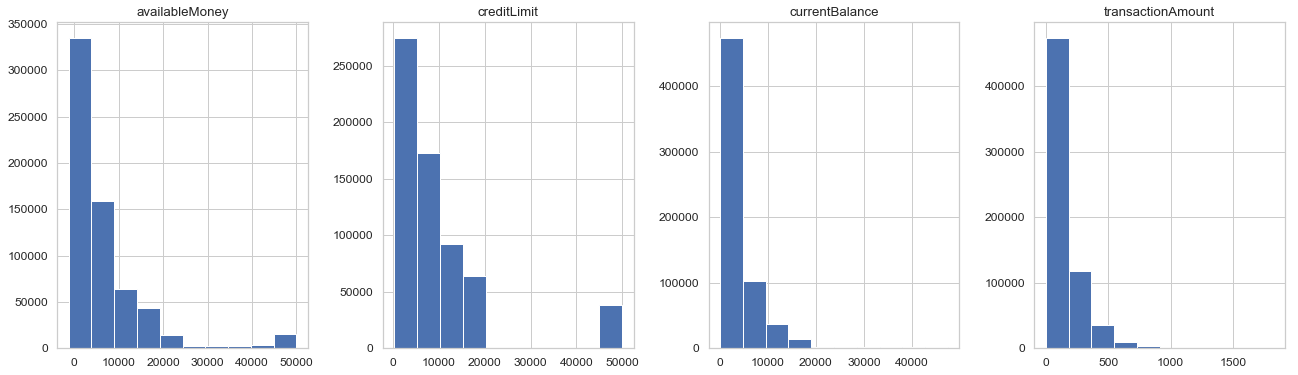

In [20]:
transactions[numeric_columns].hist(figsize=(22, 6), layout=(1, 4))

#### Histogram of Transaction Amount

- The histogram for transaction amounts is right skewed as most of the transaction amounts are in the range of `$0` to `$500`. Only 1% of records are having transaction amounts greater than 500 making the distribution right skewed.

Column name: transactionAmount
Total Rows: 641914
Positive values row count: 641914
Negative values row count: 0
Null values row count: 0
Column summary
count    641914.000000
mean        135.162497
std         147.053302
min           0.000000
25%          32.320000
50%          85.800000
75%         189.030000
max        1825.250000
Name: transactionAmount, dtype: float64
Cut: [   0.     182.525  365.05   547.575  730.1    912.625 1095.15  1277.675 1460.2   1642.725 1825.25 ]
Count: [474374 117873  34855  10375   3128    945    263     72     23      6]


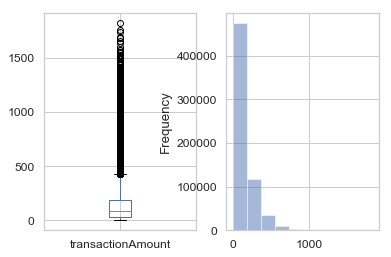

In [21]:
get_stats(transactions, ['transactionAmount'], bins=10)

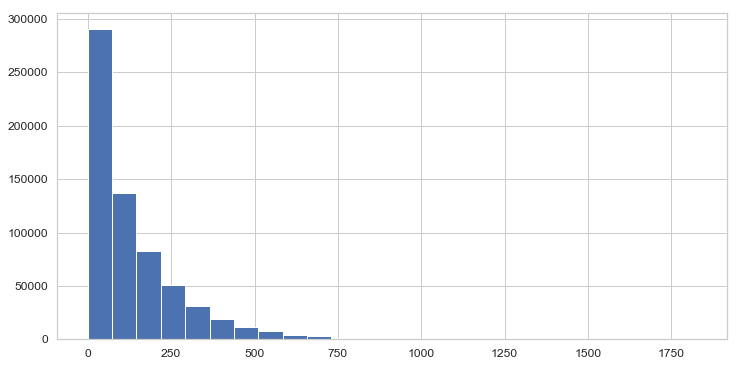

In [22]:
transactions['transactionAmount'].hist(figsize=(12, 6), bins=25)

#### Boxplots to understand the quantiles in the numeric columns also used to check for outliers

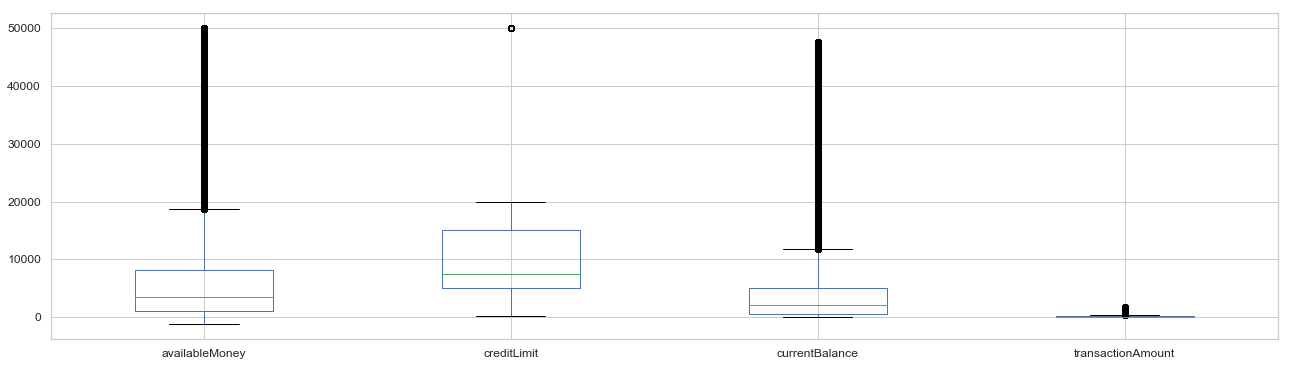

In [23]:
transactions[numeric_columns].boxplot(figsize=(22, 6))

### Visualizing distribution of fraud in the categorical columns using stacked bar charts

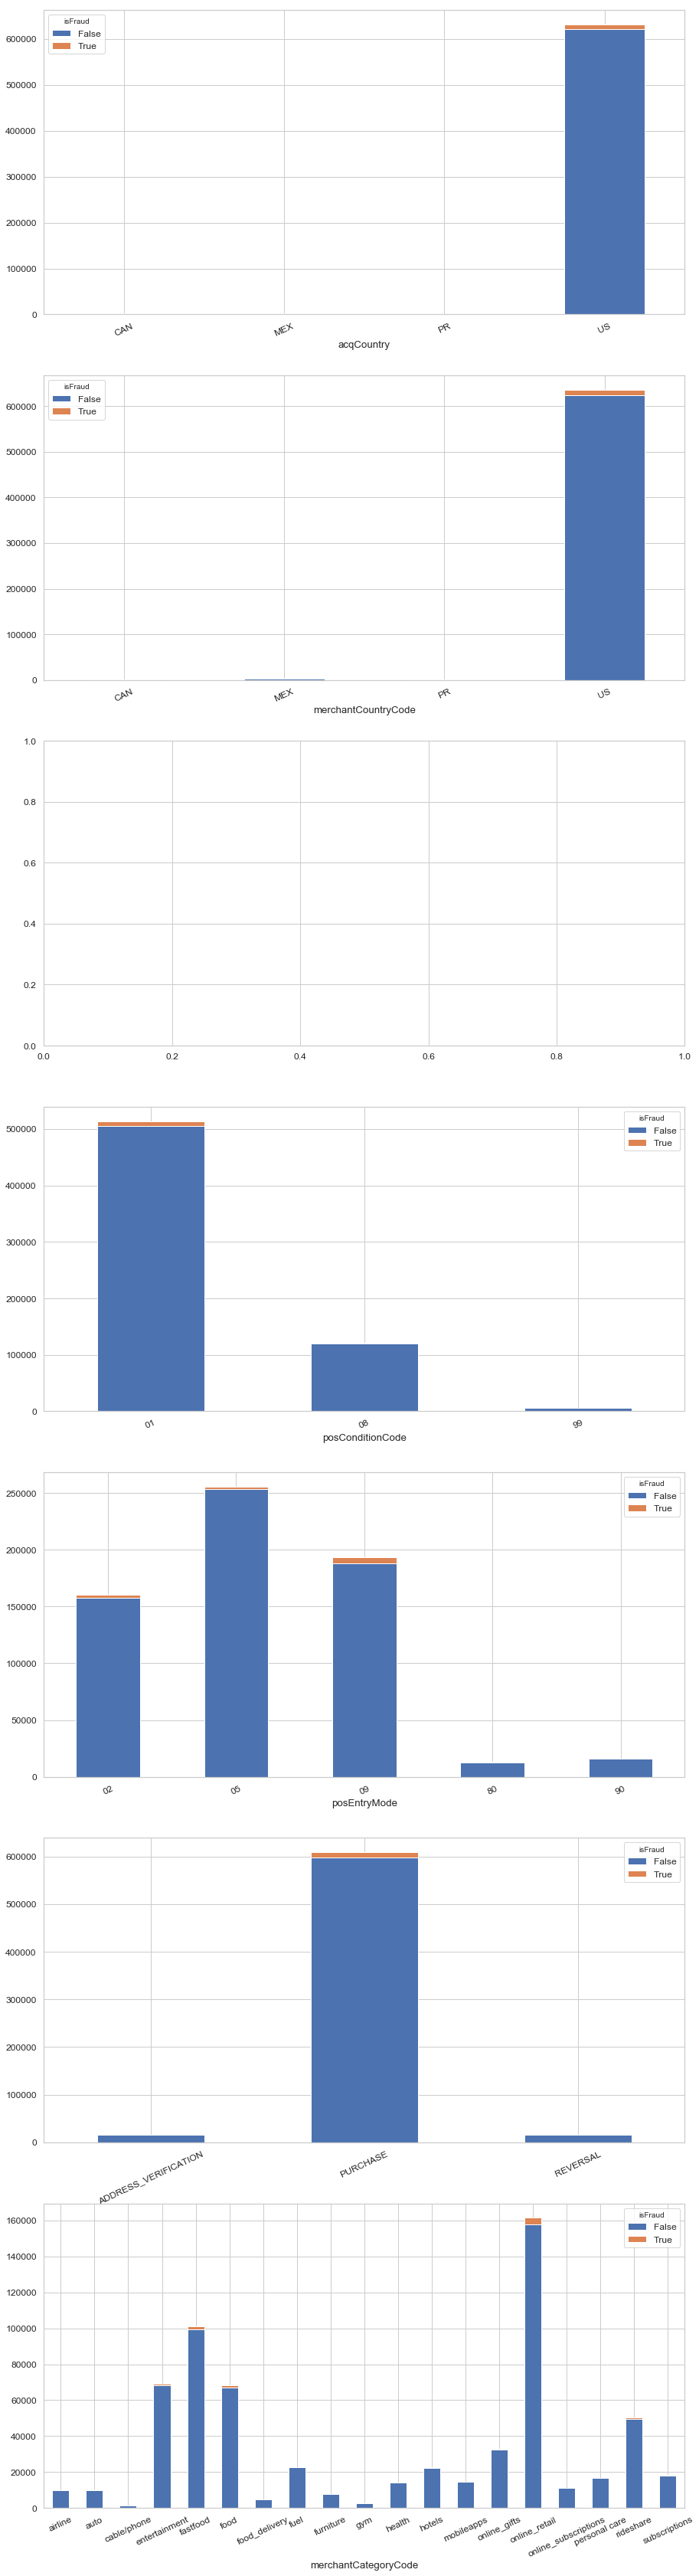

In [24]:
fig, ax = plt.subplots(len(categorical_columns), figsize=(15, 60))
for variable, subplot in zip(categorical_columns, ax.flatten()):
    if (variable != 'merchantName'):
#         sns.countplot(transactions[variable], ax=subplot)
        ct = pd.crosstab(transactions[variable], transactions['isFraud'])
        ct.plot.bar(stacked=True, ax=subplot)
        for label in subplot.get_xticklabels():
            label.set_rotation(25)

### Heatmap to visualize the proportion of fraud in the merchantCategoryCode

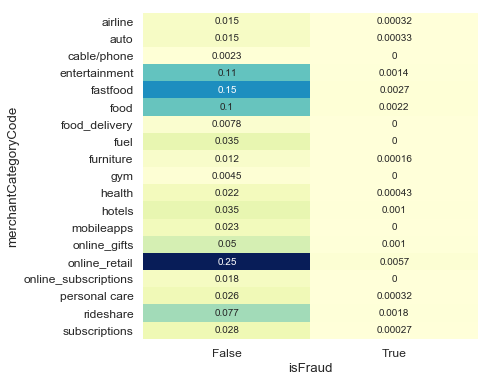

In [25]:
plt.subplots(figsize=(6,6))
sns.heatmap(pd.crosstab(transactions['merchantCategoryCode'], transactions['isFraud'], normalize=True)
                       , annot=True, cbar=False, cmap="YlGnBu")

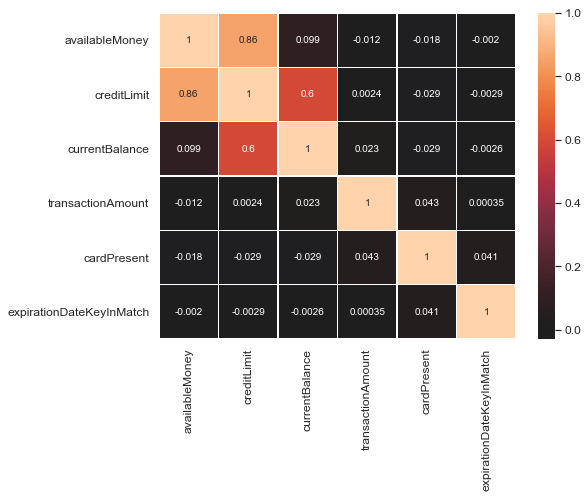

In [26]:
#creating a heatmap of the attributes in the dataset
col_list = numeric_columns + boolean_columns
correlation_matrix = transactions[col_list].corr()
plt.subplots(figsize=(8,6))
sns.heatmap(correlation_matrix, center=0, annot=True, linewidths=.3)

### Unique values in each column

In [27]:
transactions.nunique()

accountNumber                 5000
accountOpenDate               1826
acqCountry                       4
availableMoney              450690
cardCVV                        899
cardLast4Digits               5134
cardPresent                      2
creditLimit                     10
currentBalance              406990
currentExpDate                 165
customerId                    5000
dateOfLastAddressChange       2186
enteredCVV                     980
expirationDateKeyInMatch         2
isFraud                          2
merchantCategoryCode            19
merchantCountryCode              4
merchantName                  2493
posConditionCode                 3
posEntryMode                     5
transactionAmount            62735
transactionDateTime         635472
transactionType                  3
transactionDate                365
dtype: int64

#### Minimum and maximum dates in each date column

In [28]:
min(transactions['accountOpenDate']), max(transactions['accountOpenDate'])

(Timestamp('1985-12-25 00:00:00'), Timestamp('2015-12-31 00:00:00'))

In [29]:
min(transactions['transactionDateTime']), max(transactions['transactionDateTime'])

(Timestamp('2016-01-01 00:00:37'), Timestamp('2016-12-30 23:59:27'))

In [30]:
#viewing the distribution of dates in DisbursalDate column
display_all(transactions['customerId'].groupby([transactions['transactionDateTime'].dt.year
                                                ,transactions['transactionDateTime'].dt.month
                                    , transactions['isFraud']
                                   ]).agg({'count'})
           )

count
transactionDateTime transactionDateTime isFraud       
2016                1                   False    48851
                                        True       993
                    2                   False    47038
                                        True       919
                    3                   False    50985
                                        True      1017
                    4                   False    49891
                                        True       907
                    5                   False    52527
                                        True       984
                    6                   False    51703
                                        True       932
                    7                   False    53882
                                        True       988
                    8                   False    54662
                                        True       908
                    9                   False    53484
                                        True       873
                    10                  False    56352
                                        True       993
                    11                  False    55259
                                        True       901
                    12                  False    55978
                                        True       887

### Reversal transactions

In [31]:
reversed_transactions = transactions[transactions['transactionType'] == 'REVERSAL']
reversed_transactions.shape

(16162, 24)

In [32]:
round(reversed_transactions['transactionAmount'].sum(),2)

2242915.1

#### There are total of 16,162 reversal transactions in the dataset that accounts to `$2,242,915` in transaction amounts

### Multi-swipes / Duplicate transactions

In [33]:
purchases = transactions[transactions['transactionType'] == 'PURCHASE'].sort_values(['customerId'
                                                                                     , 'transactionDateTime']
                                                                                   )

In [34]:
purchases['duplicate_trxns_idx'] = purchases.groupby(['customerId', 'merchantName',
                                  'transactionDate', 'transactionAmount']
                                )["accountNumber"].cumcount() + 1

In [35]:
multi_swipes = purchases[purchases['duplicate_trxns_idx'] > 1]
multi_swipes.shape

(5983, 25)

In [36]:
round(multi_swipes['transactionAmount'].sum(),2)

885932.79

#### There are total of 5983 duplicate transactions in the dataset that accounts to `$885,932.79` in transaction amounts

#### Share of reversal and multiswipe transactions only account to 3.45% of transactions. 

### Feature Engineering

In [37]:
transactions = transactions[transactions['accountOpenDate'] >= '2000-01-01']
transactions.shape

(641882, 24)

In [38]:
transactions = transactions.sort_values(['customerId', 'transactionDateTime'])
transactions.shape

(641882, 24)

In [39]:
# Creating a column to check for multiswipe transactions
transactions['multiswipe_txns'] = transactions.groupby(['customerId', 'merchantName',
                                  'transactionDate', 'transactionAmount']
                                )["accountNumber"].cumcount() + 1

### Basic Features

In [40]:
transactions['account_age'] = (transactions['transactionDate'] - transactions['accountOpenDate']).dt.days

In [41]:
transactions['days_to_expire'] = (transactions['currentExpDate'] - transactions['transactionDate']).dt.days

In [42]:
transactions['card_valid_days'] = (transactions['currentExpDate'] - transactions['accountOpenDate']).dt.days

In [43]:
transactions['days_from_recent_addr_change'] = (transactions['transactionDate'] - transactions['dateOfLastAddressChange']
                                               ).dt.days

In [44]:
transactions['days_from_open_addr_change'] = (transactions['dateOfLastAddressChange'] - transactions['accountOpenDate']
                                               ).dt.days

In [45]:
transactions['same_country_flag'] = transactions['acqCountry'] == transactions['merchantCountryCode']

In [46]:
transactions['valid_details_flag'] = transactions['enteredCVV'] == transactions['cardCVV']

In [47]:
transactions['risky_category_flag'] = np.where(transactions['merchantCategoryCode'].isin(['online_retail'
                                                                                             ,'entertainment'
                                                                                             ,'fastfood'
                                                                                             ,'food'
                                                                                             ,'rideshare'
                                                                                            ])
                                               ,1,0
                                              )

### Temporal features

In [48]:
# Cumulative count of transactions by customer
transactions.sort_values(["customerId", "transactionDateTime"], ascending=True, inplace = True)
transactions["trxn_idx_customerid"] = transactions.groupby("customerId")["accountNumber"].cumcount() + 1

In [49]:
transactions['days_since_last_trxn'] = transactions.groupby("customerId"
                                                           )["transactionDate"].diff().apply(lambda x: x.days)

In [50]:
# Cumulative count of transactions by customer and merchant
transactions.sort_values(["customerId", "merchantName", "transactionDateTime"], inplace = True, ascending=True)
transactions["trxn_idx_customerid_merchantname"] = transactions.groupby(["customerId"
                                                                        , "merchantName"]
                                                                      )["accountNumber"].cumcount() + 1

In [51]:
transactions[['company','StoreNo']] = transactions.merchantName.str.split(" #", n = 1, expand=True) 

In [52]:
# Cumulative count of transactions by customer and company
transactions.sort_values(["customerId", "company", "transactionDateTime"], inplace = True, ascending=True)
transactions["trxn_idx_customerid_company"] = transactions.groupby(["customerId"
                                                                    , "company"]
                                                                      )["accountNumber"].cumcount() + 1

In [53]:
transactions['days_since_last_trxn_company'] = transactions.groupby(['customerId'
                                                                   , 'company'
                                                                     ])['transactionDate'
                                                                       ].diff().apply(lambda x: x.days)

In [54]:
# Cumulative count of transactions by customer and merchant category
transactions.sort_values(["customerId", "merchantCategoryCode", "transactionDateTime"], inplace = True, ascending=True)
transactions["trxn_idx_customerid_category"] = transactions.groupby(["customerId"
                                                                    , "merchantCategoryCode"]
                                                                      )["accountNumber"].cumcount() + 1

In [55]:
transactions['days_since_last_trxn_category'] = transactions.groupby(['customerId'
                                                                   , 'merchantCategoryCode'
                                                                     ])['transactionDate'
                                                                       ].diff().apply(lambda x: x.days)

### Ratio Features

In [56]:
transactions['tr_amt_age_ratio'] = transactions['transactionAmount']/transactions['account_age']
transactions['cr_limit_age_ratio'] = transactions['creditLimit']/transactions['account_age']
transactions['tr_amt_limit_ratio'] = transactions['transactionAmount']/transactions['creditLimit']
transactions['avail_amt_limit_ratio'] = transactions['availableMoney']/transactions['creditLimit']
transactions['cur_bal_limit_ratio'] = transactions['currentBalance']/transactions['creditLimit']

In [57]:
transactions['tr_amt_curbal_ratio'] = np.where(transactions['currentBalance'] > 0
                                               ,transactions['transactionAmount']/transactions['currentBalance']
                                               ,0
                                              )
transactions['avail_amt_curbal_ratio'] = np.where(transactions['currentBalance'] > 0
                                               ,transactions['availableMoney']/transactions['currentBalance']
                                               ,0
                                              )
transactions['tr_avail_amt_ratio'] = np.where(transactions['availableMoney'] > 0
                                               ,transactions['transactionAmount']/transactions['availableMoney']
                                               ,0
                                              )

### Aggregated features

In [58]:
# MIN, MAX, MEAN, MEDIAN of transaction amount by customer
customer_transactionAmount = transactions.groupby(['customerId'], as_index=False)['transactionAmount'].agg(['min'
                                                                                ,'max'
                                                                                ,'mean'
                                                                                ,'median'
                                                                              ]).rename(columns={'min':'min_transactionAmount'
                                                                                                ,'max':'max_transactionAmount'
                                                                                                ,'median':'median_transactionAmount'                                         
                                                                                                ,'mean':'mean_transactionAmount'
                                                                                                 }
                                                                                       )


In [59]:
transactions = pd.merge(transactions, customer_transactionAmount, on='customerId', how='left')

In [60]:
# MIN, MAX, MEAN, MEDIAN of transaction amount by merchant category
customer_merchantcode_txn = transactions.groupby(['merchantCategoryCode'], as_index=False)['transactionAmount'].agg(['min'
                                                                                ,'max'
                                                                                ,'mean'
                                                                                ,'median'
                                                                              ]).rename(columns={'min':'min_merchcode_txnAmt'
                                                                                                ,'max':'max_merchcode_txnAmt'
                                                                                                ,'median':'mediancode_merch_txnAmt'                                         
                                                                                                ,'mean':'mean_merchcode_txnAmt'
                                                                                                 }
                                                                                       )


In [61]:
transactions = pd.merge(transactions, customer_merchantcode_txn, on=['merchantCategoryCode'], how='left')

In [62]:
# MIN, MAX, MEAN, MEDIAN of transaction amount by store
customer_merchant_txn = transactions.groupby(['StoreNo'], as_index=False)['transactionAmount'].agg(['min'
                                                                                ,'max'
                                                                                ,'mean'
                                                                                ,'median'
                                                                              ]).rename(columns={'min':'min_merch_txnAmt'
                                                                                                ,'max':'max_merch_txnAmt'
                                                                                                ,'median':'median_merch_txnAmt'                                         
                                                                                                ,'mean':'mean_merch_txnAmt'
                                                                                                 }
                                                                                       )


In [63]:
transactions = pd.merge(transactions, customer_merchant_txn, on=['StoreNo'], how='left')

In [64]:
# MIN, MAX, MEAN, MEDIAN of transaction amount by company
customer_company_txn = transactions.groupby(['company'], as_index=False)['transactionAmount'].agg(['min'
                                                                                ,'max'
                                                                                ,'mean'
                                                                                ,'median'
                                                                              ]).rename(columns={'min':'min_comp_txnAmt'
                                                                                                ,'max':'max_comp_txnAmt'
                                                                                                ,'median':'median_comp_txnAmt'                                         
                                                                                                ,'mean':'mean_comp_txnAmt'
                                                                                                 }
                                                                                       )

In [65]:
transactions = pd.merge(transactions, customer_company_txn, on=['company'], how='left')

In [66]:
# MIN, MAX, MEAN, MEDIAN of transaction amount by posconditioncode
customer_poscode_txn = transactions.groupby(['posConditionCode'], as_index=False)['transactionAmount'].agg(['min'
                                                                                ,'max'
                                                                                ,'mean'
                                                                                ,'median'
                                                                              ]).rename(columns={'min':'min_poscode_txnAmt'
                                                                                                ,'max':'max_poscode_txnAmt'
                                                                                                ,'median':'median_poscode_txnAmt'                                         
                                                                                                ,'mean':'mean_poscode_txnAmt'
                                                                                                 }
                                                                                       )


In [67]:
transactions = pd.merge(transactions, customer_poscode_txn, on=['posConditionCode'], how='left')

In [68]:
# MIN, MAX, MEAN, MEDIAN of transaction amount by posentrymode
customer_posmode_txn = transactions.groupby(['posEntryMode'], as_index=False)['transactionAmount'].agg(['min'
                                                                                ,'max'
                                                                                ,'mean'
                                                                                ,'median'
                                                                              ]).rename(columns={'min':'min_posmode_txnAmt'
                                                                                                ,'max':'max_posmode_txnAmt'
                                                                                                ,'median':'median_posmode_txnAmt'                                         
                                                                                                ,'mean':'mean_posmode_txnAmt'
                                                                                                 }
                                                                                       )


In [69]:
transactions = pd.merge(transactions, customer_posmode_txn, on=['posEntryMode'], how='left')

In [70]:
# MIN, MAX, MEAN, MEDIAN of transaction amount by cardpresent
customer_cardprsnt_txn = transactions.groupby(['cardPresent'], as_index=False)['transactionAmount'].agg(['min'
                                                                                ,'max'
                                                                                ,'mean'
                                                                                ,'median'
                                                                              ]).rename(columns={'min':'min_cardprsnt_txnAmt'
                                                                                                ,'max':'max_cardprsnt_txnAmt'
                                                                                                ,'median':'median_cardprsnt_txnAmt'                                         
                                                                                                ,'mean':'mean_cardprsnt_txnAmt'
                                                                                                 }
                                                                                       )

In [71]:
transactions = pd.merge(transactions, customer_cardprsnt_txn, on=['cardPresent'], how='left')

In [72]:
# unique credit cards of customer
customer_cards = transactions.groupby(['customerId'])['cardLast4Digits'].nunique().reset_index().rename(
    columns={'cardLast4Digits':'cards_count'}
                                                                                       )

In [73]:
transactions = pd.merge(transactions, customer_cards, on=['customerId'], how='left')

In [74]:
# same day merchant transaction count
sameday_merch_trxns = transactions.groupby(['customerId'
                                 ,'transactionDate'
                                 ,'merchantName'])['cardLast4Digits'].nunique().reset_index().rename(columns={'cardLast4Digits':
                                                                                      'txn_count'}).sort_values(['txn_count']
                                                                                                               ,ascending=False)

In [75]:
transactions = pd.merge(transactions, sameday_merch_trxns, on=['customerId'
                                                              ,'transactionDate'
                                                              ,'merchantName'
                                                              ], how='left')

In [76]:
# same day company transaction count
sameday_comp_trxns = transactions.groupby(['customerId'
                                 ,'transactionDate'
                                 ,'company'])['cardLast4Digits'].nunique().reset_index().rename(columns={'cardLast4Digits':
                                                                                      'comp_txn_count'}).sort_values(['comp_txn_count']
                                                                                                               ,ascending=False)

In [77]:
transactions = pd.merge(transactions, sameday_comp_trxns, on=['customerId'
                                                              ,'transactionDate'
                                                              ,'company'
                                                              ], how='left')

In [78]:
# generating date features
for col in date_columns:
    generate_date_features(transactions, col, drop=False)

In [79]:
transactions.shape

(641882, 145)

In [80]:
# changing object data type to category
train_cats(transactions)

In [81]:
transactions['isFraud'] = np.where(transactions['isFraud'] == True, 1, 0)

### Model Building

In [82]:
train = transactions[transactions['transactionDate'] < '2016-12-01']
test = transactions[transactions['transactionDate'] >= '2016-12-01']

In [83]:
def target_encode(df_tr, columns):
    for col in columns:
        print(col)
        cumsum = df_tr.groupby(col)['isFraud'].cumsum() -  df_tr['isFraud']
        cumcnt = df_tr.groupby(col).cumcount()
        df_tr[col+'_mean_target'] = cumsum/cumcnt
        df_tr[col+'_mean_target'].fillna(df_tr[col+'_mean_target'].mean(),inplace=True)
    return df_tr

In [84]:
train = target_encode(train, ['company', 'merchantCategoryCode', 'merchantName'])

company


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


merchantCategoryCode
merchantName


In [85]:
# Entropy features
company_target = train.groupby(['company'], as_index=False)['company_mean_target'].agg(['mean']).rename(columns={'mean':'company_mean_target'
                                                                                                 }
                                                                                       )

category_target = train.groupby(['merchantCategoryCode'], as_index=False)['merchantCategoryCode_mean_target'].agg(['mean']).rename(columns={'mean':'merchantCategoryCode_mean_target'
                                                                                                 }
                                                                                       )

merchant_target = train.groupby(['merchantName'], as_index=False)['merchantName_mean_target'].agg(['mean']).rename(columns={'mean':'merchantName_mean_target'
                                                                                                 }
                                                                                       )

In [86]:
test = pd.merge(test, company_target, on=['company'], how='left')
test = pd.merge(test, category_target, on=['merchantCategoryCode'], how='left')
test = pd.merge(test, merchant_target, on=['merchantName'], how='left')

In [87]:
company_entropy = train.groupby(['customerId'])['company'].apply(entropy).reset_index().rename(columns={'company':
                                                                                                       'company_entropy'
                                                                                                       }
                                                                                                      )

category_entropy = train.groupby(['customerId'])['merchantCategoryCode'].apply(entropy).reset_index().rename(columns={'merchantCategoryCode':
                                                                                                               'category_entropy'
                                                                                                               }
                                                                                                      )

merchant_entropy = train.groupby(['customerId'])['merchantName'].apply(entropy).reset_index().rename(columns={'merchantName':
                                                                                                               'merchant_entropy'
                                                                                                               }
                                                                                                      )



In [88]:
train = pd.merge(train, company_entropy, on=['customerId'], how='left')
train = pd.merge(train, category_entropy, on=['customerId'], how='left')
train = pd.merge(train, merchant_entropy, on=['customerId'], how='left')

In [89]:
test = pd.merge(test, company_entropy, on=['customerId'], how='left')
test = pd.merge(test, category_entropy, on=['customerId'], how='left')
test = pd.merge(test, merchant_entropy, on=['customerId'], how='left')

In [90]:
unwanted_cols = ['accountNumber'
                 ,'accountOpenDate'
                 ,'currentExpDate'
                 ,'customerId'
                 ,'dateOfLastAddressChange'
                 ,'transactionDateTime'
#                  ,'multiswipe_txns'
                 ,'cardCVV'
                 ,'cardLast4Digits'
                 ,'enteredCVV'
                 ,'merchantName'
                 ,'StoreNo'
                ]

In [91]:
df_train, y_train, nas = proc_df(train, 'isFraud', skip_flds=unwanted_cols, ignore_flds=['transactionDate'])
df_test, y_test, nas = proc_df(test, 'isFraud', skip_flds=unwanted_cols, ignore_flds=['transactionDate'])

In [92]:
## Splitting the data set into train and validation
X_trn, X_val, y_trn, y_val = train_test_split_sorted(df_train
                                                     , y_train
                                                     , 0.195
                                                     , df_train['transactionDate']
                                                    )

In [93]:
min(X_trn['transactionDate']), max(X_trn['transactionDate'])

(Timestamp('2016-01-01 00:00:00'), Timestamp('2016-09-30 00:00:00'))

In [94]:
min(X_val['transactionDate']), max(X_val['transactionDate'])

(Timestamp('2016-09-30 00:00:00'), Timestamp('2016-11-30 00:00:00'))

In [95]:
X_trn.drop('transactionDate', axis=1, inplace=True)
X_val.drop('transactionDate', axis=1, inplace=True)
df_test.drop('transactionDate', axis=1, inplace=True)
display_all(X_trn.head())

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


acqCountry  availableMoney  cardPresent  creditLimit  currentBalance  \
729            4         7500.00            2         7500            0.00   
1210           4         5000.00            1         5000            0.00   
1814           4         5000.00            1         5000            0.00   
2117           4        10000.00            2        10000            0.00   
2118           4         9994.04            2        10000            5.96   

      expirationDateKeyInMatch  merchantCategoryCode  merchantCountryCode  \
729                      False                     4                    4   
1210                     False                    15                    4   
1814                     False                    15                    4   
2117                     False                     4                    4   
2118                     False                     4                    4   

      posConditionCode  posEntryMode  transactionAmount  transactionType  \
729                  1             3              53.42                2   
1210                 2             3              80.42                2   
1814                 1             3              79.61                2   
2117                 1             3               5.96                2   
2118                 1             1              32.77                2   

      multiswipe_txns  account_age  days_to_expire  card_valid_days  \
729                 1          915            5722             6637   
1210                1          225            1155             1380   
1814                1          321            4961             5282   
2117                1          825            4961             5786   
2118                1          825             974             1799   

      days_from_recent_addr_change  days_from_open_addr_change  \
729                            915                           0   
1210                           225                           0   
1814                           321                           0   
2117                           825                           0   
2118                           825                           0   

      same_country_flag  valid_details_flag  risky_category_flag  \
729                True                True                    1   
1210               True                True                    1   
1814               True                True                    1   
2117               True                True                    1   
2118               True                True                    1   

      trxn_idx_customerid  days_since_last_trxn  \
729                     1                   1.0   
1210                    1                   1.0   
1814                    1                   1.0   
2117                    1                   1.0   
2118                    2                   0.0   

      trxn_idx_customerid_merchantname  company  trxn_idx_customerid_company  \
729                                  1       62                            1   
1210                                 1      186                            1   
1814                                 1      194                            1   
2117                                 1       14                            1   
2118                                 1       62                            1   

      days_since_last_trxn_company  trxn_idx_customerid_category  \
729                            7.0                             1   
1210                           7.0                             1   
1814                           7.0                             1   
2117                           7.0                             1   
2118                           7.0                             2   

      days_since_last_trxn_category  tr_amt_age_ratio  cr_limit_age_ratio  \
729                             1.0          0.058383            8.196721   
1210                            1

In [96]:
def print_scores(model_name, ml_model):
    
    print(f'Scores for {model_name} model\n')
    if(model_name != 'Light GBM'):
        valid_preds_prob = ml_model.predict_proba(X_val)[:,1]
        test_preds_prob = ml_model.predict_proba(df_test)[:,1]
        
    if(model_name == 'Light GBM'):
        valid_preds_prob = ml_model.predict(X_val)
        test_preds_prob = ml_model.predict(df_test)
    
    valid_fpr, valid_tpr, valid_thresholds = metrics.roc_curve(y_val, valid_preds_prob)
    
    test_fpr, test_tpr, test_thresholds = metrics.roc_curve(y_test, test_preds_prob)

    print(f'Valid AUC : {round(metrics.auc(valid_fpr, valid_tpr),3)}')
    
    print(f'Test AUC : {round(metrics.auc(test_fpr, test_tpr),3)}\n')
        
    plt.plot(valid_fpr, valid_tpr, 'g', label = 'Valid AUC = %0.3f' %metrics.auc(valid_fpr, valid_tpr))
    plt.plot(test_fpr, test_tpr, 'b', label = 'Test AUC = %0.3f' %metrics.auc(test_fpr, test_tpr))
    plt.legend(loc='lower right')
    plt.plot([0,1], [0,1], 'r--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.rcParams['font.size'] = 12
    plt.title(f'ROC curve - {model_name} model')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.grid(True)

## LightGBM Model implementation

In [97]:
lgtrain = lgb.Dataset(X_trn, y_trn) #, categorical_feature=categorical_columns
lgval = lgb.Dataset(X_val, y_val) #, categorical_feature=categorical_columns

params = {
    "objective" : "binary",
    "metric" : "auc",
    "boosting": "gbdt",
    "max_depth" : 7,
    "learning_rate" : 0.01,
    "feature_fraction" : 0.7,
    "bagging_fraction" : 0.7,
    "verbosity" : -1,
    "is_unbalance" : True,
    "random_seed" : 2019
}
evals_result = {}
lgb_model = lgb.train(params
                  , lgtrain
                  , 3000
                  , valid_sets = [lgval, lgtrain]
                  , valid_names = ['valid', 'train']
                  , early_stopping_rounds=50
                  , verbose_eval=100
                  , feature_name=X_trn.columns.tolist()
                  , evals_result=evals_result
                 )

Training until validation scores don't improve for 50 rounds.
[100]	train's auc: 0.81004	valid's auc: 0.805544
[200]	train's auc: 0.819151	valid's auc: 0.80963
[300]	train's auc: 0.828467	valid's auc: 0.81395
[400]	train's auc: 0.836815	valid's auc: 0.817229
[500]	train's auc: 0.844878	valid's auc: 0.820098
[600]	train's auc: 0.852563	valid's auc: 0.822567
[700]	train's auc: 0.859373	valid's auc: 0.824293
[800]	train's auc: 0.865445	valid's auc: 0.825339
[900]	train's auc: 0.871077	valid's auc: 0.825854
[1000]	train's auc: 0.87658	valid's auc: 0.826494
[1100]	train's auc: 0.881592	valid's auc: 0.827066
[1200]	train's auc: 0.886227	valid's auc: 0.827579
[1300]	train's auc: 0.890748	valid's auc: 0.82817
Early stopping, best iteration is:
[1324]	train's auc: 0.891811	valid's auc: 0.828296


### Feature importance

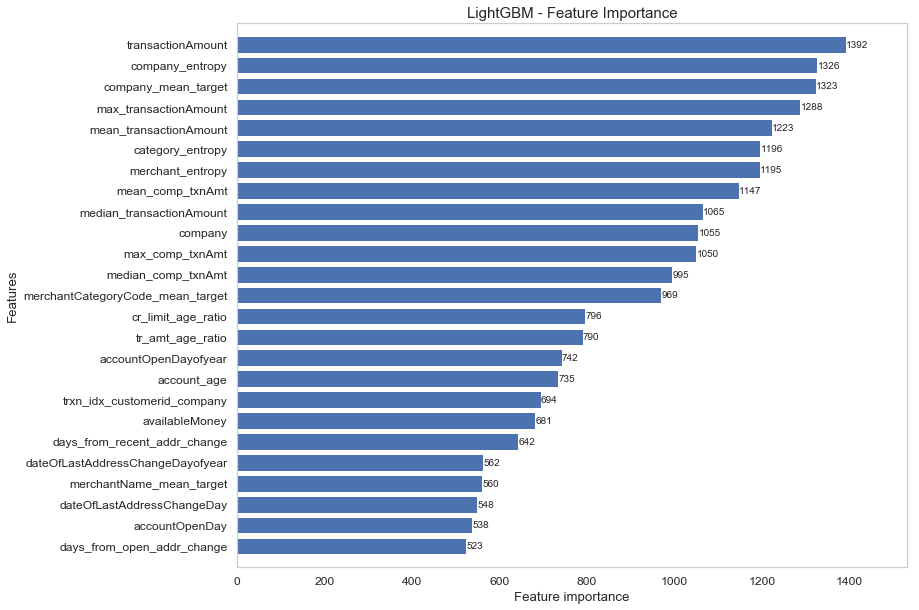

In [98]:
# Top 25 features
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(lgb_model, max_num_features=25, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

#### Transaction amount is the most important feature followed by company_mean_entropy and company_mean_target.

Plotting metrics recorded during training...


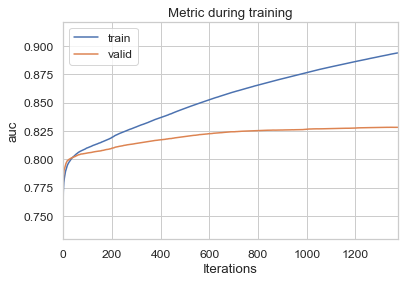

In [99]:
print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='auc')
plt.show()

Scores for Light GBM model

Valid AUC : 0.828
Test AUC : 0.829



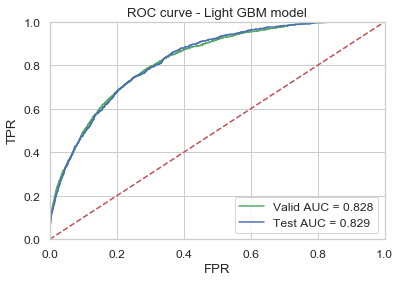

In [100]:
print_scores('Light GBM', lgb_model)

#### The validation and the test auc scores are consistent and the model did not overfit on the training data. 